In [1]:
import sys
sys.path.insert(0, "/home/jogi/git/repository/meta_learner")


import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

from datetime import datetime
from pytz import timezone
import itertools
import copy

import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
from collections import OrderedDict


from models.rnn_optimizer import MetaLearner, AdaptiveMetaLearnerV1, AdaptiveMetaLearnerV2
from models.rnn_optimizer import kl_divergence
from utils.utils import Experiment, get_model, create_def_argparser, get_experiment, create_logger
from utils.plots import loss_plot, param_error_plot, plot_qt_probs, create_x_val_array, plot_kl_div_parts
from utils.plots import get_exper_loss_data, plot_val_result, plot_exper_losses, plot_parm_loss_steps
from utils.plots import plot_qt_mode_hist
from utils.probs import TimeStepsDist, ConditionalTimeStepDist
from utils.config import config
from val_optimizer import validate_optimizer
from utils.regression import RegressionFunction, L2LQuadratic, neg_log_likelihood_loss

%load_ext autoreload
%autoreload 2

In [2]:
expers_to_load = [(False, "run_20170629_15_06_49_metaV1_10ep_100ops_retrain_lr5e06_adam"), # quadratics
                  (False, "run_20170625_18_56_22_metaV1_60ep_100ops_retrain_lr5e06_adam"), # quadratics
                  (False, "run_20170629_16_58_08_metaV1_10ep_100ops_retrain_lr5e06_adam"), # 30eps/without BPTT
                  (False, "run_20170627_18_12_50_metaV1_10ep_100ops_retrain_lr1e06_adam"), # 30eps/with BPTT
                  # ACT V2 model (1 LSTM)
                  (True, "run_20170628_21_23_35_actV2_40ep_100ops_retrain_lr1e06_adam"), # q=0.90 / lr 1e-6 / 70eps
                  (True, "run_20170630_09_00_26_actV2_70ep_100ops_lr5e06_adam"), # 0.95 / lr5e-6 / 70eps
                  (True, "run_20170629_19_58_02_actV2_40ep_100ops_retrain_lr5e06_adam"),  # 0.80 / lr5e-6 / 70 eps
                  (True, "run_20170629_22_12_52_actV2_70ep_100ops_lr5e06_adam"), # 0.98 / lr 5e-6 / 70 eps
                  (True, "run_20170629_19_55_41_actV2_40ep_100ops_retrain_lr5e06_adam")] # server 0.85 / 5e-6 / 80 eps



In [3]:
without_models = False

experiments = []
models = []
new_experiments = []
explogger = None
m = 0
for e, exp_path in enumerate(expers_to_load):
    if exp_path[0]:
        exp = get_experiment(exp_path[1])
        print("{} Loading model {}".format(m, exp.args.model))
        
        experiments.append(exp)
        if explogger is None:
            explogger = create_logger(exp, file_handler=False)
        m += 1
        if not without_models:
            models.append(get_model(exp, exp.args.x_dim, retrain=True, logger=explogger))
        new_experiments.append(copy.deepcopy(exp))
        new_experiments[-1].reset_val_stats()


0 Loading model actV2_regression_100ops
Using cuda for MetaLearner


INFO - INFO - loaded existing model from file logs/run_20170628_21_23_35_actV2_40ep_100ops_retrain_lr1e06_adam/actV2_regression_100ops.pkl


['linear1.weight', 'linear1.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1.fc_h2h.bias', 'linear_out.weight', 'act_linear_out.weight']


INFO - INFO - loaded existing model from file logs/run_20170630_09_00_26_actV2_70ep_100ops_lr5e06_adam/actV2_regression_100ops.pkl


1 Loading model actV2_regression_100ops
Using cuda for MetaLearner
['linear1.weight', 'linear1.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1.fc_h2h.bias', 'linear_out.weight', 'act_linear_out.weight']


INFO - INFO - loaded existing model from file logs/run_20170629_19_58_02_actV2_40ep_100ops_retrain_lr5e06_adam/actV2_regression_100ops.pkl


2 Loading model actV2_regression_100ops
Using cuda for MetaLearner
['linear1.weight', 'linear1.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1.fc_h2h.bias', 'linear_out.weight', 'act_linear_out.weight']


INFO - INFO - loaded existing model from file logs/run_20170629_22_12_52_actV2_70ep_100ops_lr5e06_adam/actV2_regression_100ops.pkl


3 Loading model actV2_regression_100ops
Using cuda for MetaLearner
['linear1.weight', 'linear1.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1.fc_h2h.bias', 'linear_out.weight', 'act_linear_out.weight']


INFO - INFO - loaded existing model from file logs/run_20170629_19_55_41_actV2_40ep_100ops_retrain_lr5e06_adam/actV2_regression_100ops.pkl


4 Loading model actV2_regression_100ops
Using cuda for MetaLearner
['linear1.weight', 'linear1.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1.fc_h2h.bias', 'linear_out.weight', 'act_linear_out.weight']


In [4]:
for e in experiments:
    print("{}: q-prob {:.3f}".format(e.args.log_dir, e.config.continue_prob))

run_20170628_21_23_35_actV2_40ep_100ops_retrain_lr1e06_adam: q-prob 0.900
run_20170630_09_00_26_actV2_70ep_100ops_lr5e06_adam: q-prob 0.950
run_20170629_19_58_02_actV2_40ep_100ops_retrain_lr5e06_adam: q-prob 0.800
run_20170629_22_12_52_actV2_70ep_100ops_lr5e06_adam: q-prob 0.980
run_20170629_19_55_41_actV2_40ep_100ops_retrain_lr5e06_adam: q-prob 0.850


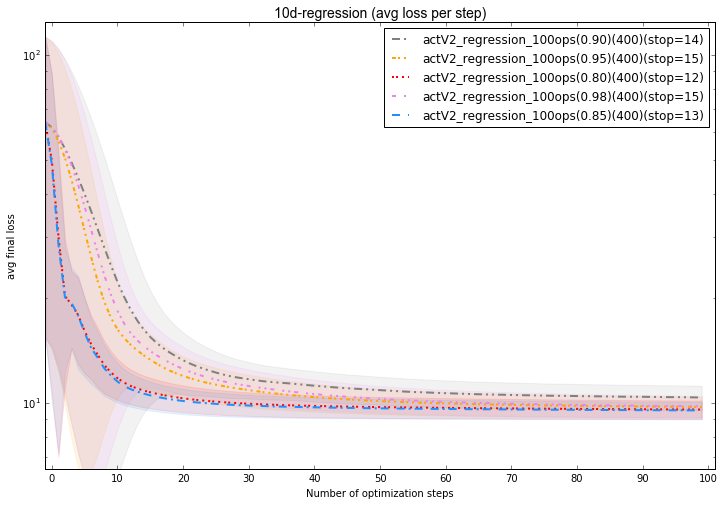

In [15]:
new_exp_only = [new_experiments[0], new_experiments[1], new_experiments[2] ] #, new_experiments[4]]
best_val_runs, lowest_value = plot_val_result(new_experiments, do_show=True, 
                                              do_save=False, 
                                              plot_best=False,
                                              fig_name="10-dim regression", 
                                              loss_type="loss",
                                              max_step=101,
                                              sort_exper="10d-regression",
                                              log_scale=True,
                                              with_stddev=True)

INFO - Successfully saved fig logs/run_20170602_19_20_08_actV2_60ep_20ops_lr1e05_adam/qt_T_dist_train_actV2_60ep_20ops.png


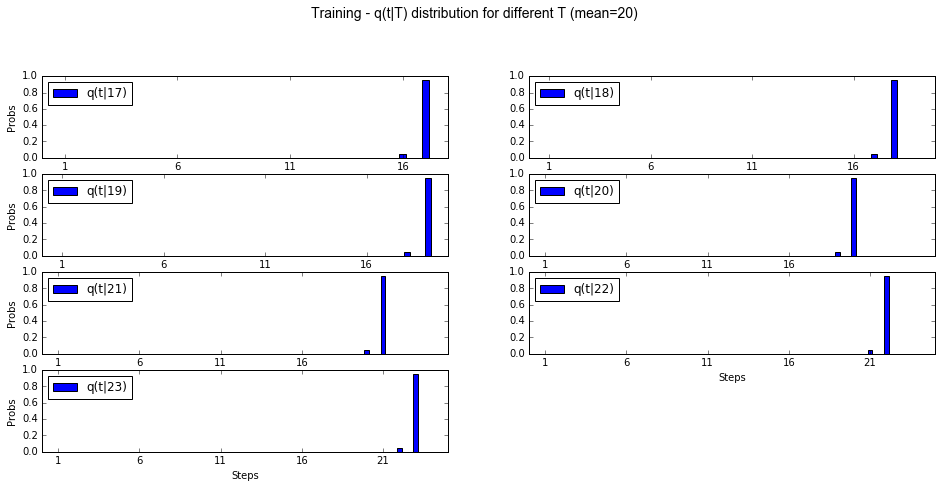

In [12]:
plot_qt_probs(experiments[1], data_set="train", show=True, plot_prior=False, save=True)

actV2_lr1e-05_adam_10ops


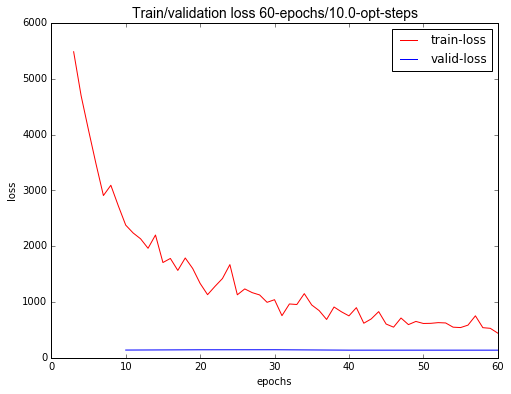

actV2_lr1e-05_adam_20ops


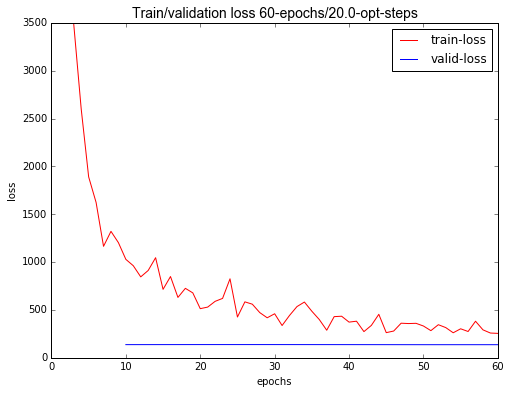

actV2_lr1e-05_adam_40ops


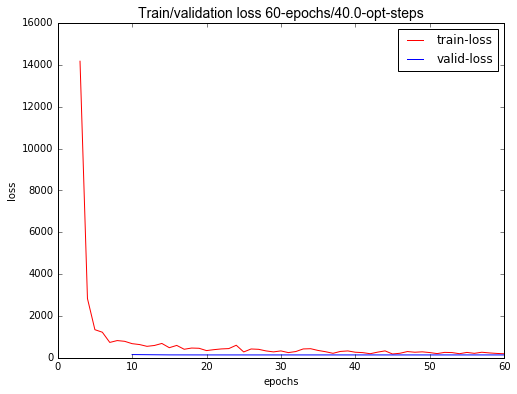

In [4]:
# exp_error_curves = [experiments[0],  experiments[3]]
for exp, mdl in zip(experiments, models):
    print(mdl.name)
    loss_plot(exp, loss_type="loss", save=False, validation=True, show=True)


INFO - Successfully saved fig figures/expv5_val_results_1000_loss_10ops_12_01_09.png


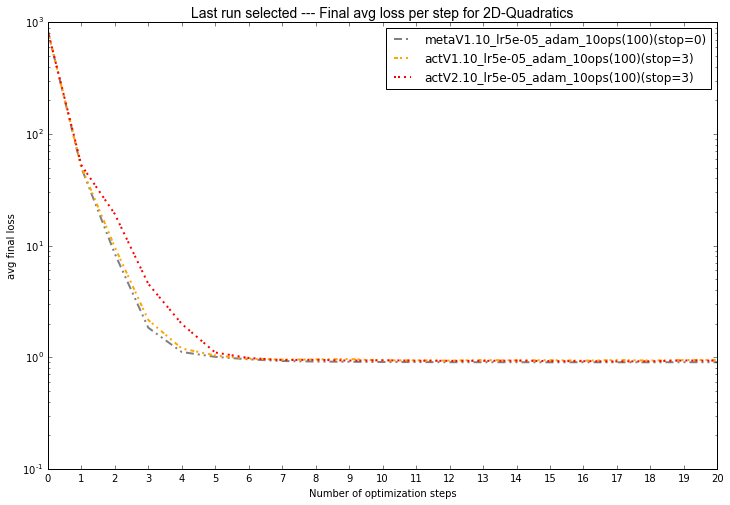

In [27]:
# eval_new_val_expers = [new_experiments[0], new_experiments[3]] #, new_experiments[5]]

best_val_runs, lowest_value = plot_val_result(new_experiments, 
                                              do_show=True, 
                                              do_save=True, 
                                              plot_best=False,
                                              loss_type="loss",
                                              fig_name="expv5_val_results_1000_loss_10ops")

In [14]:
for exp in experiments:
    print(exp.config.max_val_opt_steps)

40
40
40
40
50
40


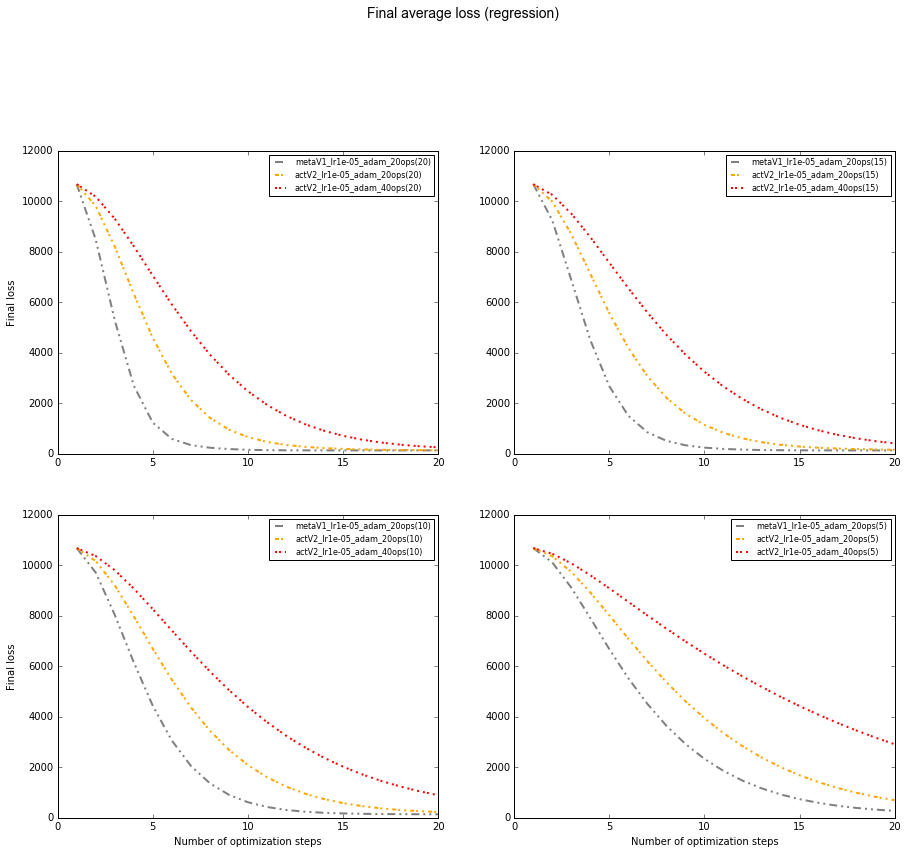

In [5]:
# eval_expers = new_exp_only = [experiments[0], experiments[1], experiments[2]]
plot_parm_loss_steps(experiments, num_of_plots=4, do_show=True, 
                     do_save=False, loss_type="loss", log_scale=False, max_step=20,
                    fig_name="metaV2_val_loss_during_training")

In [2]:
val_funcs = RegressionFunction(n_funcs=20000, n_samples=10, stddev=1.0, 
                             x_dim=10, use_cuda=True)
with open("data/val_funcs_20000_10_1.0_10.dll", 'wb') as f:
     dill.dump(val_funcs, f)
print("Success")

Success


In [4]:
"""
    Create some new validation functions
"""
num_of_val_funcs = 20000
val_funcs = L2LQuadratic(batch_size=num_of_val_funcs, num_dims=10, stddev=0.01, use_cuda=True)
print("Ready")

Ready


In [4]:
with open("data/test_funcs_20000.dll", 'rb') as f:
    val_funcs = dill.load(f)
print("Success")

Success


In [6]:
val_funcs = RegressionFunction(n_funcs=20000, n_samples=10, stddev=1., 
                             x_dim=10, use_cuda=True, calc_true_params=False)
print("Ready")

Ready


In [12]:
print(len(new_experiments))
exp_idx = 4
max_steps = 100
new_experiments[exp_idx].epoch = 400
new_experiments[exp_idx].config.max_val_opt_steps = max_steps
new_experiments[exp_idx].config.T = max_steps
# the same object for the validation data
model = models[exp_idx]
model.opt_step_hist_val = np.zeros(new_experiments[exp_idx].config.max_val_opt_steps)
model.qt_hist_val = OrderedDict([(i, np.zeros(i)) 
                                 for i in np.arange(1, new_experiments[exp_idx].config.max_val_opt_steps + 1)])
print("Validating model {} with q-prob {:.3f}".format(model.name, experiments[exp_idx].config.continue_prob))

if "act" in model.name:
    model.init_qt_statistics(new_experiments[exp_idx].config)

validate_optimizer(model, new_experiments[exp_idx], explogger, val_set=val_funcs, 
                   max_steps=max_steps, verbose=False, plot_func=False, show_plot=False, save_plot=False,
                   num_of_plots=5, save_model=False, save_qt_prob_funcs=True)

INFO - ---------------------------------------------------------------------------------------
INFO - INFO - Epoch 400: Validating model actV2_regression_100ops with 20000 functions


5
Validating model actV2_regression_100ops with q-prob 0.850


INFO - INFO - Epoch 400, elapsed time 21.51 seconds: 
INFO - INFO - Epoch 400: Final validation stats: total-step-losses / final-step loss / final-true_min: 1.148e+03/9.537/0.3477
INFO - INFO - Epoch 400: Final validation average ACT-loss: 11.43
INFO - INFO - Epoch 400: Average stopping-step: 13
INFO - INFO - Epoch 400: Final step losses: [ 64.12   48.477  28.651  20.142  19.416  17.861  15.944  14.403  13.502
  12.59   12.01   11.539  11.208  10.975  10.798  10.655  10.533  10.43
  10.343  10.27   10.207  10.151  10.102  10.059  10.021   9.988   9.958
   9.932   9.908   9.887   9.867   9.85    9.833   9.819   9.805   9.793
   9.781   9.77    9.76    9.751   9.742   9.734   9.726   9.719   9.712
   9.705   9.698   9.692   9.687   9.681   9.676   9.671   9.666   9.661
   9.656   9.652   9.648   9.644   9.64    9.636   9.632   9.628   9.625
   9.621   9.618   9.615   9.612   9.609   9.606   9.603   9.6     9.597
   9.594   9.592   9.589   9.587   9.584   9.582   9.579   9.577   9.575
   

In [156]:
# exper = get_experiment('run_20170515_13_53_49_actV2_20ep_10ops_lr5e05_adam')
exper = get_experiment("run_20170525_19_39_19_actV2_30ep_20ops_lr5e05_adam")

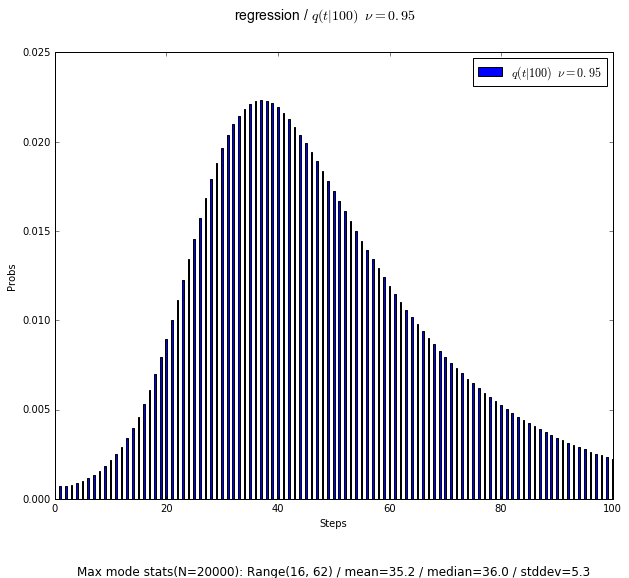

In [9]:
plot_qt_probs(new_experiments[1], data_set="val", save=False, show=True, 
              plot_prior=False, height=20, width=20, add_info=True)

In [122]:
from utils.plots import create_exper_label
num_of_plots = 13
T0 = 23
fig = plt.figure(figsize=(8, 25))

for i in range(1, num_of_plots+1):
    T = T0+i
    index = np.arange(1, T+1).astype(int)
    qt = exper.val_stats["qt_hist"][30][T]
    ax1 = plt.subplot(num_of_plots, 1, i)
    plt.bar(index, qt, 0.3, label="q(t|{})".format(T))
    ax1.legend(loc="best")
    
fig_name = "_" + "val" + "_" + create_exper_label(exper)
fig_name = os.path.join(exper.output_dir, config.qt_dist_prefix + fig_name + ".png")
plt.savefig(fig_name, bbox_inches='tight')
plt.close()

('key ', 100)
INFO - Successfully saved fig logs/run_20170630_09_00_26_actV2_70ep_100ops_lr5e06_adam/qt_mode_stats_actV2_70ep_100ops.png


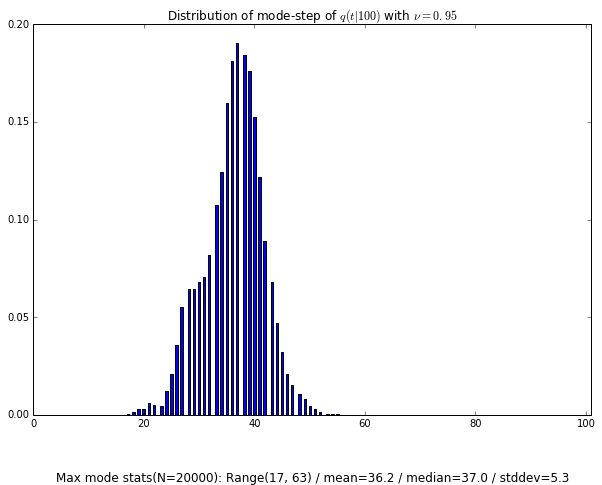

In [13]:
plot_qt_mode_hist(new_experiments[1], do_save=True, do_show=True, add_info=True)

(20000, 100)


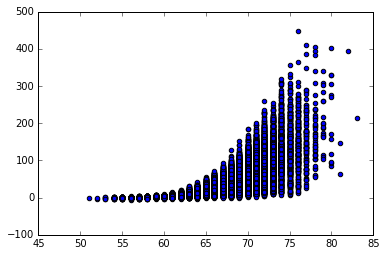

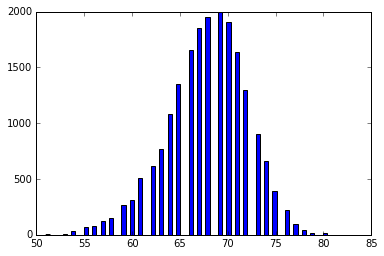

In [33]:
def compute_yt(W, x):
    return torch.transpose(torch.mm(W ,x.unsqueeze(1)), 1,0)

def compute_params(W, y, cuda=False):
    
    A_plus = np.linalg.pinv(W.data.cpu().numpy())
    y = y.data.cpu().numpy()
    params = np.squeeze(np.dot(A_plus, y))
    params = Variable(torch.from_numpy(params).float().unsqueeze(0))
    if cuda:
        params = params.cuda()
    return params
    
exp_idx = 1
threshold = 0.85

nll_init = neg_log_likelihood_loss(val_funcs.y, val_funcs.y_t(val_funcs.initial_params), 
                              val_funcs.stddev, N=val_funcs.n_samples, 
                              sum_batch=False,
                              size_average=False)
nll_min = neg_log_likelihood_loss(val_funcs.y, val_funcs.y_t(val_funcs.true_params), 
                              val_funcs.stddev, N=val_funcs.n_samples, 
                              sum_batch=False,
                              size_average=False)

nll_distance = (nll_init - nll_min).data.cpu().squeeze().numpy()
qt_probs = new_experiments[exp_idx].val_stats["qt_funcs"][100]
max_idx_probs = np.argmax(qt_probs, 1) + 1
qt_cdf = np.cumsum(qt_probs, 1)
print(qt_cdf.shape)

# stops = np.searchsorted(qt_cdf[2, :], threshold)
stops_steps = np.apply_along_axis(lambda a: a.searchsorted(threshold) + 1, axis = 1, arr = qt_cdf)

# _ = plt.scatter(max_idx_probs, nll_distance)
# plt.show()
# plt.close()

_ = plt.scatter(stops_steps, nll_distance)
plt.show()
plt.close()

_ = plt.hist(stops_steps, bins="auto")
plt.show()
plt.close()

(20000,)
(19984,)


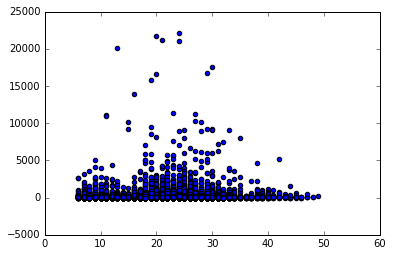

In [218]:
true_params = np.sum(np.abs(val_funcs.true_params.data.cpu().squeeze().numpy()), 1)
true_params = true_params.astype(int)
print(true_params.shape)
true_idx = true_params < 25000
print(true_params[true_idx].shape)
_ = plt.scatter(max_idx_probs[true_idx], true_params[true_idx])

In [ ]:
 # 
plot_kl_div_parts(new_experiments[1], save=False, show=True, final_terms=False, log_qt=True, plot_prior=True,
                 fig_name="kl_parts_without_tanh")